# Fusion Model Comparison

This notebook trains and compares three multimodal fusion strategies on the cubes vs. spheres binary classification task:
- **Late Fusion**: two separate encoders, outputs joined before classification
- **Intermediate Fusion (Concat)**: parallel conv paths, feature maps concatenated mid-network
- **Intermediate Fusion (Matmul)**: parallel conv paths, feature maps combined via matrix multiplication


In [9]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam

from datasets import create_pytorch_dataset_from_fo
from models import LateNet, CatIntermediateNet, MatmulIntermediateNet, AddIntermediateNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
DATASET_NAME = "cilp_assessment"
BATCH_SIZE   = 32

train_ds, val_ds, train_loader, val_loader = create_pytorch_dataset_from_fo(
    DATASET_NAME, batch_size=BATCH_SIZE, device=device
)

# Sanity check
rgb, xyza, label = train_ds[0]
print("RGB:", rgb.shape, " XYZA:", xyza.shape, " Label:", label.item())


Extracted train dataset of size 15998 and validation dataset of size 4000
Train: 15998 samples | Val: 4000 samples
RGB: torch.Size([3, 64, 64])  XYZA: torch.Size([4, 64, 64])  Label: 0.0


Lets define our hyperparameters, which we will keep constant for all models.

In [12]:
EPOCHS  = 20
LR      = 1e-4  # TODO: Learning rate scheduler
# TODO: log to w&b and log f1 score

Finally, before running the experiments, we setup the experiment on weights & biases.

In [13]:
import wandb
import numpy as np

wandb.login()

run = wandb.init(project="fusion_architecture_comparison")

wandb.config.update({
    #"Learning Rate": LR,
    "Epochs": EPOCHS,
    "Batch Size": BATCH_SIZE,
    "n_train": len(train_ds),
    "n_val": len(val_ds)    
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Late Fusion
Lets start by implementing a late fusion approach using the embedder and classifier in the models file.


In [14]:
late_net = LateNet().to(device)
late_opt = Adam(late_net.parameters(), lr=LR)
print(late_net)


LateNet(
  (rgb_enc): Embedder(
    (conv): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Flatten(start_dim=1, end_dim=-1)
    )
    (dense_emb): Sequential(
      (0): Linear(in_features=3200, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=200

In [15]:
from training import *

In [16]:
late_train_losses, late_val_losses, late_best_f1, _ = run_training(
    late_net, late_opt, EPOCHS, train_loader, val_loader, device
)
for epoch, (tl, vl) in enumerate(zip(late_train_losses, late_val_losses)):
    run.log({"epoch": epoch, "Late/train_loss": tl, "Late/val_loss": vl, "Late/lr": late_opt.param_groups[0]["lr"]})


0.9661466479301453
Epoch   0 | Train: 0.3884  Val: 0.1189


KeyboardInterrupt: 

## Intermediate Fusion — Concatenation

Parallel conv paths process RGB and LiDAR independently through three conv+pool blocks. Their feature maps are concatenated along the channel dimension and passed into shared fully-connected layers.


In [ ]:
cat_net = CatIntermediateNet().to(device)
cat_opt = Adam(cat_net.parameters(), lr=LR)
print(cat_net)


CatIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(200, 200, kernel_size=(3, 3),

In [ ]:
cat_train_losses, cat_val_losses, cat_best_f1, _ = run_training(
    cat_net, cat_opt, EPOCHS, train_loader, val_loader, device
)
for epoch, (tl, vl) in enumerate(zip(cat_train_losses, cat_val_losses)):
    run.log({"epoch": epoch, "Intermediate (Cat)/train_loss": tl, "Intermediate (Cat)/val_loss": vl, "Intermediate (Cat)/lr": cat_opt.param_groups[0]["lr"]})


0.9947469234466553
Epoch   0 | Train: 0.3533  Val: 0.0252
0.9987493753433228
Epoch   1 | Train: 0.0123  Val: 0.0040
0.9987493753433228
Epoch   2 | Train: 0.0061  Val: 0.0207
1.0
Epoch   3 | Train: 0.0015  Val: 0.0004
1.0
Epoch   4 | Train: 0.0001  Val: 0.0008
1.0
Epoch   5 | Train: 0.0000  Val: 0.0004
1.0
Epoch   6 | Train: 0.0000  Val: 0.0006
1.0
Epoch   7 | Train: 0.0000  Val: 0.0005
1.0
Epoch   8 | Train: 0.0000  Val: 0.0001
1.0
Epoch   9 | Train: 0.0000  Val: 0.0003
1.0
Epoch  10 | Train: 0.0000  Val: 0.0005
1.0
Epoch  11 | Train: 0.0000  Val: 0.0003
1.0
Epoch  12 | Train: 0.0000  Val: 0.0004
1.0
Epoch  13 | Train: 0.0000  Val: 0.0003
1.0
Epoch  14 | Train: 0.0000  Val: 0.0002
1.0
Epoch  15 | Train: 0.0000  Val: 0.0002
1.0
Epoch  16 | Train: 0.0000  Val: 0.0003
1.0
Epoch  17 | Train: 0.0000  Val: 0.0001
1.0
Epoch  18 | Train: 0.0000  Val: 0.0001
1.0
Epoch  19 | Train: 0.0000  Val: 0.0001


## Intermediate Fusion — Matrix Multiplication

Same parallel conv architecture as CatNet, but the two `(B, 100, 8, 8)` feature maps are **matrix-multiplied** along the spatial dimensions instead of concatenated. This lets different spatial regions of each modality interact with each other.


In [ ]:
matmul_net = MatmulIntermediateNet().to(device)
matmul_opt = Adam(matmul_net.parameters(), lr=LR)
print(matmul_net)


MatmulIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 

In [ ]:
matmul_train_losses, matmul_val_losses, matmul_best_f1, _ = run_training(
    matmul_net, matmul_opt, EPOCHS, train_loader, val_loader, device
)
for epoch, (tl, vl) in enumerate(zip(matmul_train_losses, matmul_val_losses)):
    run.log({"epoch": epoch, "Intermediate (Matmul)/train_loss": tl, "Intermediate (Matmul)/val_loss": vl, "Intermediate (Matmul)/lr": matmul_opt.param_groups[0]["lr"]})


0.9380733966827393
Epoch   0 | Train: 0.2182  Val: 0.1945
0.9964983463287354
Epoch   1 | Train: 0.0255  Val: 0.0118
0.9964983463287354
Epoch   2 | Train: 0.0206  Val: 0.0129
0.9964983463287354
Epoch   3 | Train: 0.0168  Val: 0.0083
0.9987494945526123
Epoch   4 | Train: 0.0122  Val: 0.0043
0.9987494945526123
Epoch   5 | Train: 0.0078  Val: 0.0098
0.9987494945526123
Epoch   6 | Train: 0.0089  Val: 0.0053
0.9987494945526123
Epoch   7 | Train: 0.0060  Val: 0.0041
0.9987494945526123
Epoch   8 | Train: 0.0037  Val: 0.0030
0.9987494945526123
Epoch   9 | Train: 0.0079  Val: 0.0114
0.9987494945526123
Epoch  10 | Train: 0.0063  Val: 0.0047
0.9987494945526123
Epoch  11 | Train: 0.0027  Val: 0.0049
0.9989995360374451
Epoch  12 | Train: 0.0072  Val: 0.0022
0.9989995360374451
Epoch  13 | Train: 0.0020  Val: 0.0038
0.9989995360374451
Epoch  14 | Train: 0.0043  Val: 0.0050
0.9989995360374451
Epoch  15 | Train: 0.0002  Val: 0.0079
0.9992496371269226
Epoch  16 | Train: 0.0000  Val: 0.0071
0.999249637126

## Intermediate Fusion — Addition

Same parallel conv architecture as MatmulNet and CatNet, but feature maps are combined via **element-wise addition**. Both branches must produce the same channel count (`100`). Addition is parameter-free and preserves the channel dimension, making it the lightest fusion operation.


In [ ]:
add_net = AddIntermediateNet().to(device)
add_opt = Adam(add_net.parameters(), lr=LR)
print(add_net)


AddIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3),

In [ ]:
add_train_losses, add_val_losses, add_best_f1, _ = run_training(
    add_net, add_opt, EPOCHS, train_loader, val_loader, device
)
for epoch, (tl, vl) in enumerate(zip(add_train_losses, add_val_losses)):
    run.log({"epoch": epoch, "Intermediate (Add)/train_loss": tl, "Intermediate (Add)/val_loss": vl, "Intermediate (Add)/lr": add_opt.param_groups[0]["lr"]})


0.9654985666275024
Epoch   0 | Train: 0.4429  Val: 0.1465
0.997498631477356
Epoch   1 | Train: 0.0305  Val: 0.0095
0.997498631477356
Epoch   2 | Train: 0.0041  Val: 0.0130
0.9997498989105225
Epoch   3 | Train: 0.0015  Val: 0.0019
0.9997498989105225
Epoch   4 | Train: 0.0003  Val: 0.0007
0.9997498989105225
Epoch   5 | Train: 0.0001  Val: 0.0008
0.9997498989105225
Epoch   6 | Train: 0.0001  Val: 0.0039
0.9997498989105225
Epoch   7 | Train: 0.0422  Val: 0.1278
0.9997498989105225
Epoch   8 | Train: 0.0195  Val: 0.0298
0.9997498989105225
Epoch   9 | Train: 0.0013  Val: 0.0014
0.9997498989105225
Epoch  10 | Train: 0.0002  Val: 0.0005
0.9997498989105225
Epoch  11 | Train: 0.0001  Val: 0.0005
0.9997498989105225
Epoch  12 | Train: 0.0000  Val: 0.0003
0.9997498989105225
Epoch  13 | Train: 0.0000  Val: 0.0004
1.0
Epoch  14 | Train: 0.0001  Val: 0.0003
1.0
Epoch  15 | Train: 0.0000  Val: 0.0002
1.0
Epoch  16 | Train: 0.0000  Val: 0.0002
1.0
Epoch  17 | Train: 0.0000  Val: 0.0003
1.0
Epoch  18 | Tr

## Results

Validation loss comparison across all three fusion strategies.

TODO: table with metrics for different approaches. Metrics to include
Validation Loss
F1 score
Parameters (count)
Training Time (seconds/epoch) *
GPU Memory (MB)

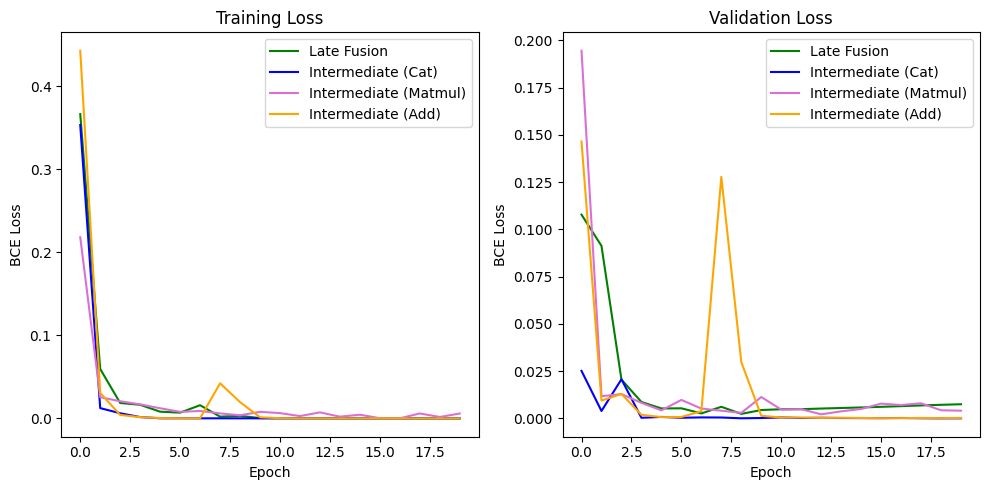

In [ ]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.plot(epochs_range, late_train_losses,   "green",   label="Late Fusion")
plt.plot(epochs_range, cat_train_losses,    "blue",    label="Intermediate (Cat)")
plt.plot(epochs_range, matmul_train_losses, "orchid",  label="Intermediate (Matmul)")
plt.plot(epochs_range, add_train_losses,    "orange",  label="Intermediate (Add)")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.plot(epochs_range, late_val_losses,   "green",   label="Late Fusion")
plt.plot(epochs_range, cat_val_losses,    "blue",    label="Intermediate (Cat)")
plt.plot(epochs_range, matmul_val_losses, "orchid",  label="Intermediate (Matmul)")
plt.plot(epochs_range, add_val_losses,    "orange",  label="Intermediate (Add)")
plt.legend()

plt.tight_layout()
plt.show()


Finally, we log the experiment results to weights & biases.

In [ ]:
def final_layer_params(model):
    """Return the parameter count of the last leaf module (typically the output linear layer)."""
    last = list(model.modules())[-1]
    return sum(p.numel() for p in last.parameters())

models_summary = [
    ("Late",                  "late",          late_net,    late_train_losses,    late_val_losses,    late_best_f1),
    ("Intermediate (Cat)",    "intermediate",  cat_net,     cat_train_losses,     cat_val_losses,     cat_best_f1),
    ("Intermediate (Matmul)", "intermediate",  matmul_net,  matmul_train_losses,  matmul_val_losses,  matmul_best_f1),
    ("Intermediate (Add)",    "intermediate",  add_net,     add_train_losses,     add_val_losses,     add_best_f1),
]

# Loss curve table (one row per epoch per model)
loss_table = wandb.Table(columns=["model", "epoch", "train_loss", "val_loss"])
for name, _, _, train_losses, val_losses, _ in models_summary:
    for epoch, (tl, vl) in enumerate(zip(train_losses, val_losses)):
        loss_table.add_data(name, epoch, tl, vl)

# Summary table (one row per model)
summary_table = wandb.Table(columns=["model", "fusion_type", "best_val_loss", "best_f1", "final_layer_params"])
for name, fusion_type, net, _, val_losses, best_f1 in models_summary:
    summary_table.add_data(name, fusion_type, min(val_losses), best_f1, final_layer_params(net))

wandb.log({
    "loss_curves": loss_table,
    "results_summary": summary_table,
})

run.finish()

Intermediate (Add)/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Add)/train_loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Add)/val_loss,█▁▂▁▁▁▁▇▂▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Cat)/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Cat)/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Cat)/val_loss,█▂▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Matmul)/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Matmul)/train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Intermediate (Matmul)/val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Late/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...
